### The most recommended books
***By Abdelhamid Tebba***

This project is about building a dataset containing the books recommended by 'world-class people'. 


### Table of contents:
<ol>
    <li><a href="#gather">Gathering</a></li>
    <li><a href="#clean">Cleaning</a></li>
    <li><a href="#store">Storing</a></li>
    <li><a href="#analyze">Analyzing</a></li>
</ol>

In [1]:
#Importing all packages
import pandas as pd
import numpy as np
import requests 
import json
from bs4 import BeautifulSoup 
from urllib import parse
import re
import time
import matplotlib.pyplot as plt
import seaborn as sb
import textwrap

%matplotlib inline

### 1. Gathering: <a id="gather"></a>

***Collecting the most recommended books:***

I came across this amazing website <a href=https://www.mostrecommendedbooks.com/>Mostrecommendedbooks.com</a> which provides all the titles recommended by some famous personalities.  
I will use this website as a first step to get all the recommendations (titles + authors). 

In the home-page of the website, you can see a list of all recommenders with anchor links to the sepecific pages. So, in order to rotate over the pages and access the books recommended by each one, I'll need to gather all the links that redirect towards these pages. 

In [14]:
def crawl(url):
    content = requests.get(url)
    soup = BeautifulSoup(content.text, 'html.parser')
    return soup

#Getting all the recommenders corresponding links:
main_page = 'https://www.mostrecommendedbooks.com/'
links = []
for tag in crawl(main_page).find_all('ul', {'class':'all-lists'}):
    for attribute in tag.find_all('a'):
        element = attribute.get('href')
        link = element.replace(element, main_page+element[1:])
        links.append(link)

In [163]:
len(links)

334

We have 334 links, which means 334 recommenders.

Now, let's get the titles and the authors recommended.

In [101]:
#Iterating over each link and building a nested dict:
books = {}

for page in links:
    soup = crawl(page)
    titles = []
    authors = []
    for tag in soup.find_all('div', {'class':'recommender-details'}):
        for name in tag.find_all('h1'):
            books[name.text] = {}
    for tag in soup.find_all('div', {'class':'text'}):
        [titles.append(title.text) for title in tag.find_all('h2')]
        [authors.append(author.text) for author in tag.find_all('h3')]
        books[name.text]['title'] =  titles
        books[name.text]['author'] = authors

The data was put into a nested dictionary 'books={}' where the names of the recommenders are the outer keys.

The next step will be to convert the dictionary to a pandas DataFrame and save it to a CSV file. 

In [124]:
df = pd.concat([pd.DataFrame(values) for values in books.values()], keys=books.keys()).reset_index(level=1, drop=True).reset_index()
df.to_csv('most_recommended.csv', index=False)

In [3]:
#Loading the data:
recommended_books = pd.read_csv(r'C:\Users\dell\Desktop\WEB_SCRAP\most_recommended.csv', header=0, names=['recommender', 'title', 'author'])
recommended_books.head()

,recommender,title,author
0,A.J. Jacobs,Enlightenment Now,Steven Pinker
1,A.J. Jacobs,Free Will,Sam Harris
2,A.J. Jacobs,Go the F**k to Sleep,Adam Mansbach
3,A.J. Jacobs,Holy Bible,-
4,A.J. Jacobs,Lying,Sam Harris


I think that removing all the holy books from the dataset is going to make it more practical for any further analysis. After digging into this data, I only found the Holy Bible. 

In [4]:
recommended_books =  recommended_books[~recommended_books['title'].str.contains('Holy Bible')]
recommended_books.query('title == "Holy Bible"').count()

recommender    0
title          0
author         0
dtype: int64

I am not interested in the recommenders as much as I am interested in the books themselves. I think that instead of having multiple rows that depict the recommenders as the main observation units, it would be better to group the data by the titles and make them our object of interest. 

So, let's tweak this DataFrame a little bit.

In [150]:
recommended_books_reshaped = recommended_books.groupby(['title', 'author'])['recommender'].apply(lambda x: '|'.join(x)).reset_index()
recommended_books_reshaped.head()

,title,author,recommender
0,"""Surely You're Joking, Mr. Feynman!""",Richard P. Feynman,Brian Armstrong|Ev Williams|Larry Page|Mark Zu...
1,"""What Do You Care What Other People Think?""",Richard P. Feynman,Larry Page|Naval Ravikant
2,10% Happier,Dan Harris,Peter Attia|Veronica Belmont
3,100 Baggers,Christopher W Mayer,DJ Vlad
4,100 Best-Loved Poems,Philip Smith,Naval Ravikant


In [159]:
recommended_books_reshaped.shape

(3003, 3)

We got 3003 observations (titles), where each title is tied to an author and a number of recommenders separated by a vertical bar.

I noticed in the two first lines that the titles are enclosed by double quotes. I don't know how much books have these characters around their titles and I will not bother myself to look for them. I will simply remove them all wherever they are in the 'title' column. 

In [160]:
#Remobing the double quotes from the 'title' column:
recommended_books_reshaped['title'] = recommended_books_reshaped['title'].str.replace('"','')

In [165]:
recommended_books_reshaped.head(1)

,title,author,recommender
0,"Surely You're Joking, Mr. Feynman!",Richard P. Feynman,Brian Armstrong|Ev Williams|Larry Page|Mark Zu...


***Scraping additional information using Google Books API:***

The DataFrame we have doesn't provide enough information about these books. We only have the titles, the authors and the recommenders. The website I used earlier doesn't have additional information such as the categroy under which the books fall or the number of pages for instance. 

One way to get this information is through Google Books API. And the easiest way to get what we need is by using the Google Book Ids or the ISBN. However, we don't neither of those. So, I will use the title and author combination in the URL search parameters. To this end, I will need to use  urllib.parse to encode non ASCII characters that can be found in the titles and authors.

In [166]:
""""
book_info = []
error_list = []
not_found = []

google_url = 'https://www.googleapis.com/books/v1/volumes?q=intitle:{}+inauthor:{}&country=MA'

headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36'}

books = recommended_books_reshaped['title'].tolist()
auths = recommended_books_reshaped['author'].tolist()

for book, auth in zip(books, auths):
    try:
        split = list(urllib.parse.urlsplit(google_url.format(book,auth)))
        split[3] = urllib.parse.quote(split[3], safe='q=&')
        url = urllib.parse.urlunsplit(split)
        s = requests.Session()
        req = s.get(url=url, headers=headers)
        data = json.loads(req.text)
        if "items" in data:
            volume_info = data["items"][0] 
            authors = volume_info["volumeInfo"]["authors"] if "authors" in volume_info["volumeInfo"] else  np.nan
            category = volume_info["volumeInfo"]["categories"] if "categories" in volume_info["volumeInfo"] else  np.nan
            pages = volume_info["volumeInfo"]["pageCount"] if "pageCount" in volume_info["volumeInfo"] else  np.nan
            publication_date = volume_info["volumeInfo"]["publishedDate"] if "publishedDate" in volume_info["volumeInfo"] else np.nan
                
            book_info.append({"google_id": volume_info['id'],
            "title": volume_info["volumeInfo"]["title"],
            "author": authors, 
            "publication_date": publication_date,
            "category": category,
            "pages": pages})
        else: 
            not_found.append(book)
    except Exception as e:
        error_list.append(e)
    time.sleep(np.random.random())
""""

In [167]:
error_list

[]

In [170]:
len(not_found)

94

94 books out of 3003 were not found using Google Books API.

In [173]:
#Converting the list of the data gartherd into a pandas dataframe:
df = pd.DataFrame(book_info, columns=['google_id', 'title', 'author', 'publication_date', 'category', 'pages'])
df

,google_id,title,author,publication_date,category,pages
0,_gA_DwAAQBAJ,"""Surely You're Joking, Mr. Feynman!"": Adventur...",[Richard P. Feynman],2018-02-06,[Biography & Autobiography],352.0
1,vbMIlkpQXEkC,"""What Do You Care What Other People Think?"": F...",[Richard P. Feynman],2011-02-14,[Biography & Autobiography],256.0
2,pINcvgEACAAJ,10% Happier,[Dan Harris],2017-01-26,[Buddhism],256.0
3,YzRKPwAACAAJ,100 Best Loved Poems,[Philip Smith],1995-10-01,[Poetry],96.0
4,KEfSAOggWXwC,100 Great Operas And Their Stories,[Henry W. Simon],2010-11-17,[Music],560.0
...,...,...,...,...,...,...
2904,2UCWAAAAQBAJ,Zero Limits,"[Joe Vitale, Ihaleakala Hew Len]",2010-06-03,[Business & Economics],256.0
2905,ZH4oAwAAQBAJ,Zero to One,"[Peter Thiel, Blake Masters]",2014-09-16,[Business & Economics],224.0
2906,3eZH7K_E6DoC,Zorba the Greek,"[Nikos Kazantzakis, Carl Wildman]",1953,[Fiction],311.0
2907,DzHJDwAAQBAJ,Zucked,[Roger McNamee],2020-02-04,[Political Science],400.0


Now, it's time to merge the tow DF 'my_df_reshaped' which contains the title, the author and the recommenders and 'my_df_cont' which contains in addition to the titles the other information retrieved through Google Books API (publication date,  size, categories).

***Merging the DataFrames:***

Since we don't have a numeric primary key (ISBN or ID) in the two DFs, and the titles in the two DF are slightly different in terms of punctuations and short vs. long titles,  the best way to merge these DFs is through the index.
But first, in order to harmonize the indexes, I need to remove from the first DataFrame all the books not found using Google Books Api.Then, after joing the two DFs, I will append the removed books. 

In [238]:
#Making a copy of the first DF:
rbr_copy = recommended_books_reshaped.copy()

In [239]:
#Removing the books that were not found via google books api:
rbr_copy = rbr_copy[(~rbr_copy.title.isin(not_found))].reset_index(drop=True)
rbr_copy

,title,author,recommender
0,"Surely You're Joking, Mr. Feynman!",Richard P. Feynman,Brian Armstrong|Ev Williams|Larry Page|Mark Zu...
1,What Do You Care What Other People Think?,Richard P. Feynman,Larry Page|Naval Ravikant
2,10% Happier,Dan Harris,Peter Attia|Veronica Belmont
3,100 Best-Loved Poems,Philip Smith,Naval Ravikant
4,100 Great Operas And Their Stories,Henry W. Simon,Eric Weinstein
...,...,...,...
2904,Zero Limits,Joe Vitale,Aubrey Marcus
2905,Zero To One,Peter Thiel,Dustin Moskovitz|Elon Musk|Eric Weinstein|Keit...
2906,Zorba the Greek,Nikos Kazantzakis,Jordan Peterson|Tim Ferriss
2907,Zucked,Roger McNamee,Marc Benioff


In [240]:
#Making the merge:
df_clean = pd.merge(rbr_copy, df, left_index=True, right_index=True)
df_clean

,title_x,author_x,recommender,google_id,title_y,author_y,publication_date,category,pages
0,"Surely You're Joking, Mr. Feynman!",Richard P. Feynman,Brian Armstrong|Ev Williams|Larry Page|Mark Zu...,_gA_DwAAQBAJ,"""Surely You're Joking, Mr. Feynman!"": Adventur...",[Richard P. Feynman],2018-02-06,[Biography & Autobiography],352.0
1,What Do You Care What Other People Think?,Richard P. Feynman,Larry Page|Naval Ravikant,vbMIlkpQXEkC,"""What Do You Care What Other People Think?"": F...",[Richard P. Feynman],2011-02-14,[Biography & Autobiography],256.0
2,10% Happier,Dan Harris,Peter Attia|Veronica Belmont,pINcvgEACAAJ,10% Happier,[Dan Harris],2017-01-26,[Buddhism],256.0
3,100 Best-Loved Poems,Philip Smith,Naval Ravikant,YzRKPwAACAAJ,100 Best Loved Poems,[Philip Smith],1995-10-01,[Poetry],96.0
4,100 Great Operas And Their Stories,Henry W. Simon,Eric Weinstein,KEfSAOggWXwC,100 Great Operas And Their Stories,[Henry W. Simon],2010-11-17,[Music],560.0
...,...,...,...,...,...,...,...,...,...
2904,Zero Limits,Joe Vitale,Aubrey Marcus,2UCWAAAAQBAJ,Zero Limits,"[Joe Vitale, Ihaleakala Hew Len]",2010-06-03,[Business & Economics],256.0
2905,Zero To One,Peter Thiel,Dustin Moskovitz|Elon Musk|Eric Weinstein|Keit...,ZH4oAwAAQBAJ,Zero to One,"[Peter Thiel, Blake Masters]",2014-09-16,[Business & Economics],224.0
2906,Zorba the Greek,Nikos Kazantzakis,Jordan Peterson|Tim Ferriss,3eZH7K_E6DoC,Zorba the Greek,"[Nikos Kazantzakis, Carl Wildman]",1953,[Fiction],311.0
2907,Zucked,Roger McNamee,Marc Benioff,DzHJDwAAQBAJ,Zucked,[Roger McNamee],2020-02-04,[Political Science],400.0


In [241]:
df_clean.drop(['title_y', 'author_y'], axis=1, inplace=True)

In [242]:
df_clean.rename(columns={'title_x':'title', 'author_x': 'author'}, inplace=True)

In [243]:
df_clean.head(1)

,title,author,recommender,google_id,publication_date,category,pages
0,"Surely You're Joking, Mr. Feynman!",Richard P. Feynman,Brian Armstrong|Ev Williams|Larry Page|Mark Zu...,_gA_DwAAQBAJ,2018-02-06,[Biography & Autobiography],352.0


In [244]:
#Creating a DF of the books not found:
not_found_df = recommended_books_reshaped[recommended_books_reshaped.title.isin(not_found)]

In [245]:
#Adding the the not found books DF to the final DF:
df_clean_ = pd.concat([df_clean, not_found_df], ignore_index=True, sort=True)

In [246]:
df_clean_.shape

(3003, 7)

Now, our new DF (df_clean_) contains  all the 3003 rows.

To clearly display the number of personalities who have recommended each title, it would be appropriate to create a new column whose values/row are the number of each name in the 'recommender' column. This 'new' column would be relevant and easier to use for any possible analysis of this number. 

In [247]:
# Creating a new column to count the number of recommenders per title
#The vertical-bar which acts as a separator between each name in'recommender' is used to make this computation
df_clean_['recommender_count'] = df_clean_['recommender'].str.count(r'\|') + 1

In [248]:
df_clean_.head(2)

,author,category,google_id,pages,publication_date,recommender,title,recommender_count
0,Richard P. Feynman,[Biography & Autobiography],_gA_DwAAQBAJ,352.0,2018-02-06,Brian Armstrong|Ev Williams|Larry Page|Mark Zu...,"Surely You're Joking, Mr. Feynman!",8
1,Richard P. Feynman,[Biography & Autobiography],vbMIlkpQXEkC,256.0,2011-02-14,Larry Page|Naval Ravikant,What Do You Care What Other People Think?,2


### 2. Cleaning:<a id="clean"></a>



In [249]:
#Ordering columns:
df_clean_ = df_clean_[['title', 'author', 'google_id', 'recommender', 'recommender_count', 'category', 'publication_date', 'pages']]

'category' values are list-like. I will remove the brackets and the quotes from each value to make them more readable

In [259]:
df_clean_['category'] = df_clean_['category'].str.join(',')

I visually noticed that dates in 'publication_date' have different formats. Sometimes it is Y/M/D and sometimes it is just the year. I also saw that some values are displayed with a timezone info. For the sake of simplicity I will only keep the year for the publication date

In [261]:
df_clean_['publication_date'] = df_clean_['publication_date'].str.replace(r'(-\d+)|([A-Za-z]\d{2}.\d{2}.\d{2}[+]\d{2}.\d{2})', '')

In [262]:
df_clean_.head(2)

,title,author,google_id,recommender,recommender_count,category,publication_date,pages
0,"Surely You're Joking, Mr. Feynman!",Richard P. Feynman,_gA_DwAAQBAJ,Brian Armstrong|Ev Williams|Larry Page|Mark Zu...,8,Biography & Autobiography,2018,352.0
1,What Do You Care What Other People Think?,Richard P. Feynman,vbMIlkpQXEkC,Larry Page|Naval Ravikant,2,Biography & Autobiography,2011,256.0


In [263]:
df_clean_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3003 entries, 0 to 3002
Data columns (total 8 columns):
title                3003 non-null object
author               3003 non-null object
google_id            2909 non-null object
recommender          3003 non-null object
recommender_count    3003 non-null int64
category             2758 non-null object
publication_date     2898 non-null object
pages                2814 non-null float64
dtypes: float64(1), int64(1), object(6)
memory usage: 187.8+ KB


'pages' should be converted to integers. But since there some NaNs, wich are special floating-point values that cannot be converted to another data type, using astype() method will produce a ValueError. Therefore,I will use the <a href= https://pandas.pydata.org/pandas-docs/stable/user_guide/integer_na.html#nullable-integer-data-type>Pandas'snullable-integer-data-type</a> which can allow  the conversion to integers with possible missing values

In [268]:
df_clean_['pages'] = df_clean_['pages'].astype('Int64')
df_clean_['pages'].dtype

Int64Dtype()

In [270]:
df_clean_.head()

,title,author,google_id,recommender,recommender_count,category,publication_date,pages
0,"Surely You're Joking, Mr. Feynman!",Richard P. Feynman,_gA_DwAAQBAJ,Brian Armstrong|Ev Williams|Larry Page|Mark Zu...,8,Biography & Autobiography,2018,352
1,What Do You Care What Other People Think?,Richard P. Feynman,vbMIlkpQXEkC,Larry Page|Naval Ravikant,2,Biography & Autobiography,2011,256
2,10% Happier,Dan Harris,pINcvgEACAAJ,Peter Attia|Veronica Belmont,2,Buddhism,2017,256
3,100 Best-Loved Poems,Philip Smith,YzRKPwAACAAJ,Naval Ravikant,1,Poetry,1995,96
4,100 Great Operas And Their Stories,Henry W. Simon,KEfSAOggWXwC,Eric Weinstein,1,Music,2010,560


Let's save our harvest in a csv file 

### 3. Storing: <a id="store"></a>

In [271]:
df_clean_.to_csv('books_clean.csv', index=False)

In [2]:
books_df = pd.read_csv(r'C:\Users\dell\Desktop\WEB_SCRAP\books_clean.csv')
books_df.head()

,title,author,google_id,recommender,recommender_count,category,publication_date,pages
0,"Surely You're Joking, Mr. Feynman!",Richard P. Feynman,_gA_DwAAQBAJ,Brian Armstrong|Ev Williams|Larry Page|Mark Zu...,8,Biography & Autobiography,2018,352.0
1,What Do You Care What Other People Think?,Richard P. Feynman,vbMIlkpQXEkC,Larry Page|Naval Ravikant,2,Biography & Autobiography,2011,256.0
2,10% Happier,Dan Harris,pINcvgEACAAJ,Peter Attia|Veronica Belmont,2,Buddhism,2017,256.0
3,100 Best-Loved Poems,Philip Smith,YzRKPwAACAAJ,Naval Ravikant,1,Poetry,1995,96.0
4,100 Great Operas And Their Stories,Henry W. Simon,KEfSAOggWXwC,Eric Weinstein,1,Music,2010,560.0


In [12]:
books_df[books_df['title'].duplicated()]

,title,author,google_id,recommender,recommender_count,category,publication_date,pages
163,All Out War,Tim Shipman,CU6oDAAAQBAJ,Marc Andreessen,1,History,2016,688.0
191,Andrew Carnegie,Joseph Frazier Wall,5g5EDwAAQBAJ,Charlie Munger,1,Biography & Autobiography,1970,1137.0
268,Benjamin Franklin,Walter Isaacson,oIW915dDMBwC,Brandon Stanton|Ed Zschau|Elon Musk|George Rav...,7,Biography & Autobiography,2003,608.0
548,Edison,Matthew Josephson,T12mDwAAQBAJ,Ryan Holiday,1,Biography & Autobiography,2019,NaN
639,Fiasco,Thomas E. Ricks,bLWJWJ0qXEAC,Bryan Callen,1,History,2007,528.0
716,Genius,James Gleick,j42RD66g72oC,Naval Ravikant,1,Biography & Autobiography,2011,532.0
1132,Mastery,Robert Greene,ObtCSg3BZBIC,Aubrey Marcus|Mark Hart|Ryan Holiday,3,Business & Economics,2012,612.0
1183,Mindfulness,Mark Williams,aV_YAAAAQBAJ,Will MacAskill,1,"Body, Mind & Spirit",2012,288.0
1656,Stalin,Oleg V. Khlevniuk,YPQ7jgEACAAJ,Brandon Stanton,1,NaN,2016,408.0
1657,Stalin,Simon Sebag Montefiore,7kZNnKlKNp4C,Elon Musk,1,Biography & Autobiography,2010,820.0


### 4. Analyzing:<a id="analyze"></a>


***What are the most recommended books among the most recommended books? :***

Let's start by plotting the distribution of the 'recommended_count' variable

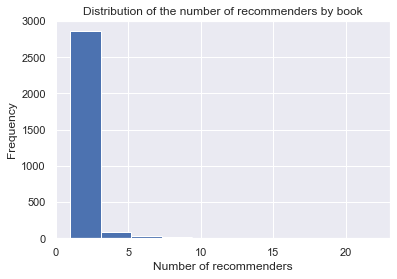

In [27]:
#Histogram:
plt.hist(data=books_df, x='recommender_count')
plt.title('Distribution of the number of recommenders by book')
plt.xlabel('Number of recommenders')
plt.ylabel('Frequency')
plt.savefig('dist.png', bbox_inches='tight');

The distribution is right-skewed and many books have less than 2 recommenders.

In [174]:
books_df.describe()

,recommender_count,pages
count,3003.000000,2814.000000
mean,1.397935,358.088842
std,1.283507,236.023922
min,1.000000,1.000000
25%,1.000000,240.000000
50%,1.000000,316.500000
75%,1.000000,416.000000
max,22.000000,5685.000000


This table shows an equal value for the 25th and 75th percentile, which literally means 0 IQR and 0 variability. This is a little bit misleading since we  don't have N identical values. The extreme values might have been ignored.

Let's see the different numbers of recommendations/book we have in this dataset

In [175]:
books_df['recommender_count'].value_counts()

1     2475
2      284
3      101
4       60
5       27
6       18
7       11
9        8
10       5
8        5
11       3
12       2
17       1
22       1
18       1
16       1
Name: recommender_count, dtype: int64

The majority of books in our dataset have only 1 recommender.

It would be interesting to see which books are at the summit of the recommendation list. Actually this is the purpose of this analysis. But since we have a long list of books (3003), not to mention that many of them have less than 2 recommenders, I can't  plot them all as it will be very condensed. So, I will consider without complicating things the number of recommenders themselves as observation units and take their median value as a minimum threshold to select the books for our analysis. It's like grouping by 'recommender_count' and taking their median.  

In [176]:
#The different numbers of recommenders/book:
num_re = books_df['recommender_count'].value_counts().index.tolist()
np.median(num_re)

8.5

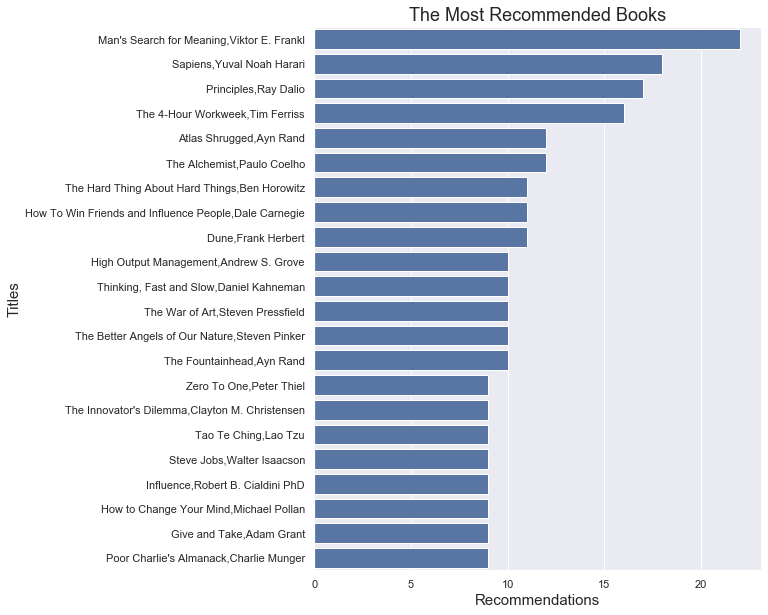

In [22]:
pd.options.mode.chained_assignment = None
#Subset of the most recommended books based on the median threshold:
data=books_df.loc[books_df.recommender_count >= 9]
#Combining titles and authors: 
data['title_y']=[','.join(i) for i in list(zip(data['title'],data['author']))]
#Barplot: 
sb.set()
plt.figure(figsize=[8,10])
color_base = sb.color_palette()[0]
sb.barplot(data=data.sort_values(by='recommender_count', ascending=False), x='recommender_count', y='title_y', color=color_base)
plt.title('The Most Recommended Books', size=18)
plt.xlabel('Recommendations', size=15)
plt.ylabel('Titles', size=15);
plt.savefig('recom.png', bbox_inches='tight')

Man's search for meaning tops the list of the most recommended books with more than 20 recommendations. Sapians (Yuval Harari) comes next, followed by "the" Principles of Ray Dalio and then The 4-hour workweek (Tim Ferriss).

It appears that most of the books in the bove barplot fall into the category of business or self-help. There are only 4 fiction books and I can hardly recognize the other categories. 

Let's drill down a  bit more into the categories in our dataset.

***What are the most frequent categories in our recommenders list?:***

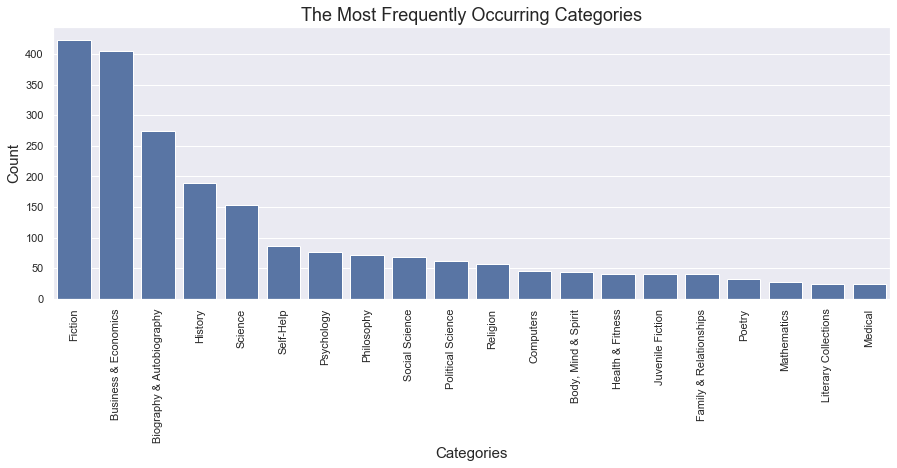

In [178]:
# Plotting the 20 most frequently occurring categories in our dataset
plt.figure(figsize=[15,5])
color_base = sb.color_palette()[0]
sb.barplot(books_df.category.value_counts().head(20).index,books_df.category.value_counts().head(20).values, color=color_base)
plt.xticks(rotation='vertical')
plt.title('The Most Frequently Occurring Categories', size=18)
plt.xlabel('Categories', size=15)
plt.ylabel('Count', size=15)
plt.savefig('cat.png', bbox_inches='tight');

Unsurprisingly, fiction and business books are the most popular with over 400 books in each of them. Biography books are the third in the list followed by history and science.
Having many books in a given category doesn't mean this category is the most recommended one nor that the books which fall under it are the most recommended above all. There's no accounting for taste. Some prefer fiction while others are more interested in economics, for instance. 
That's why in our case it would be reasonable to see the distribution of recommendations in each category. This will give us an idea about the outliers and helps us spot the most recommended books within each category 

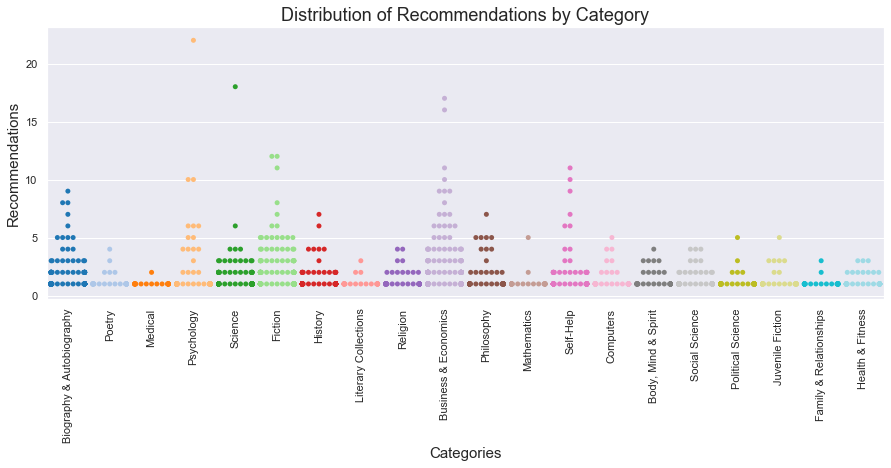

In [23]:
cat = books_df.category.value_counts().head(20).index
fig, ax = plt.subplots(figsize=[15,5])
sb.swarmplot(data=books_df[books_df.category.isin(cat)], x='category', y='recommender_count', palette='tab20')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Distribution of Recommendations by Category', size=18)
ax.set_xlabel('Categories',  size=15)
ax.set_ylabel('Recommendations',  fontsize=15)
plt.savefig('cat2.png', bbox_inches='tight')

We are seeing that most of the categories have books within the 1-5 recommendations range. Meanwhile, some of these categories have books recommended by more than 5 people,while others have books recommended by more than 10 people. Biography, business and economics, fiction, psychology, and self-help all have numerous books with many recommendations.

Now, let's find out the must-read books in each genre. I will only plot the top 5 based on the number of recommendations.


***What are the top 5 books in each category?:***

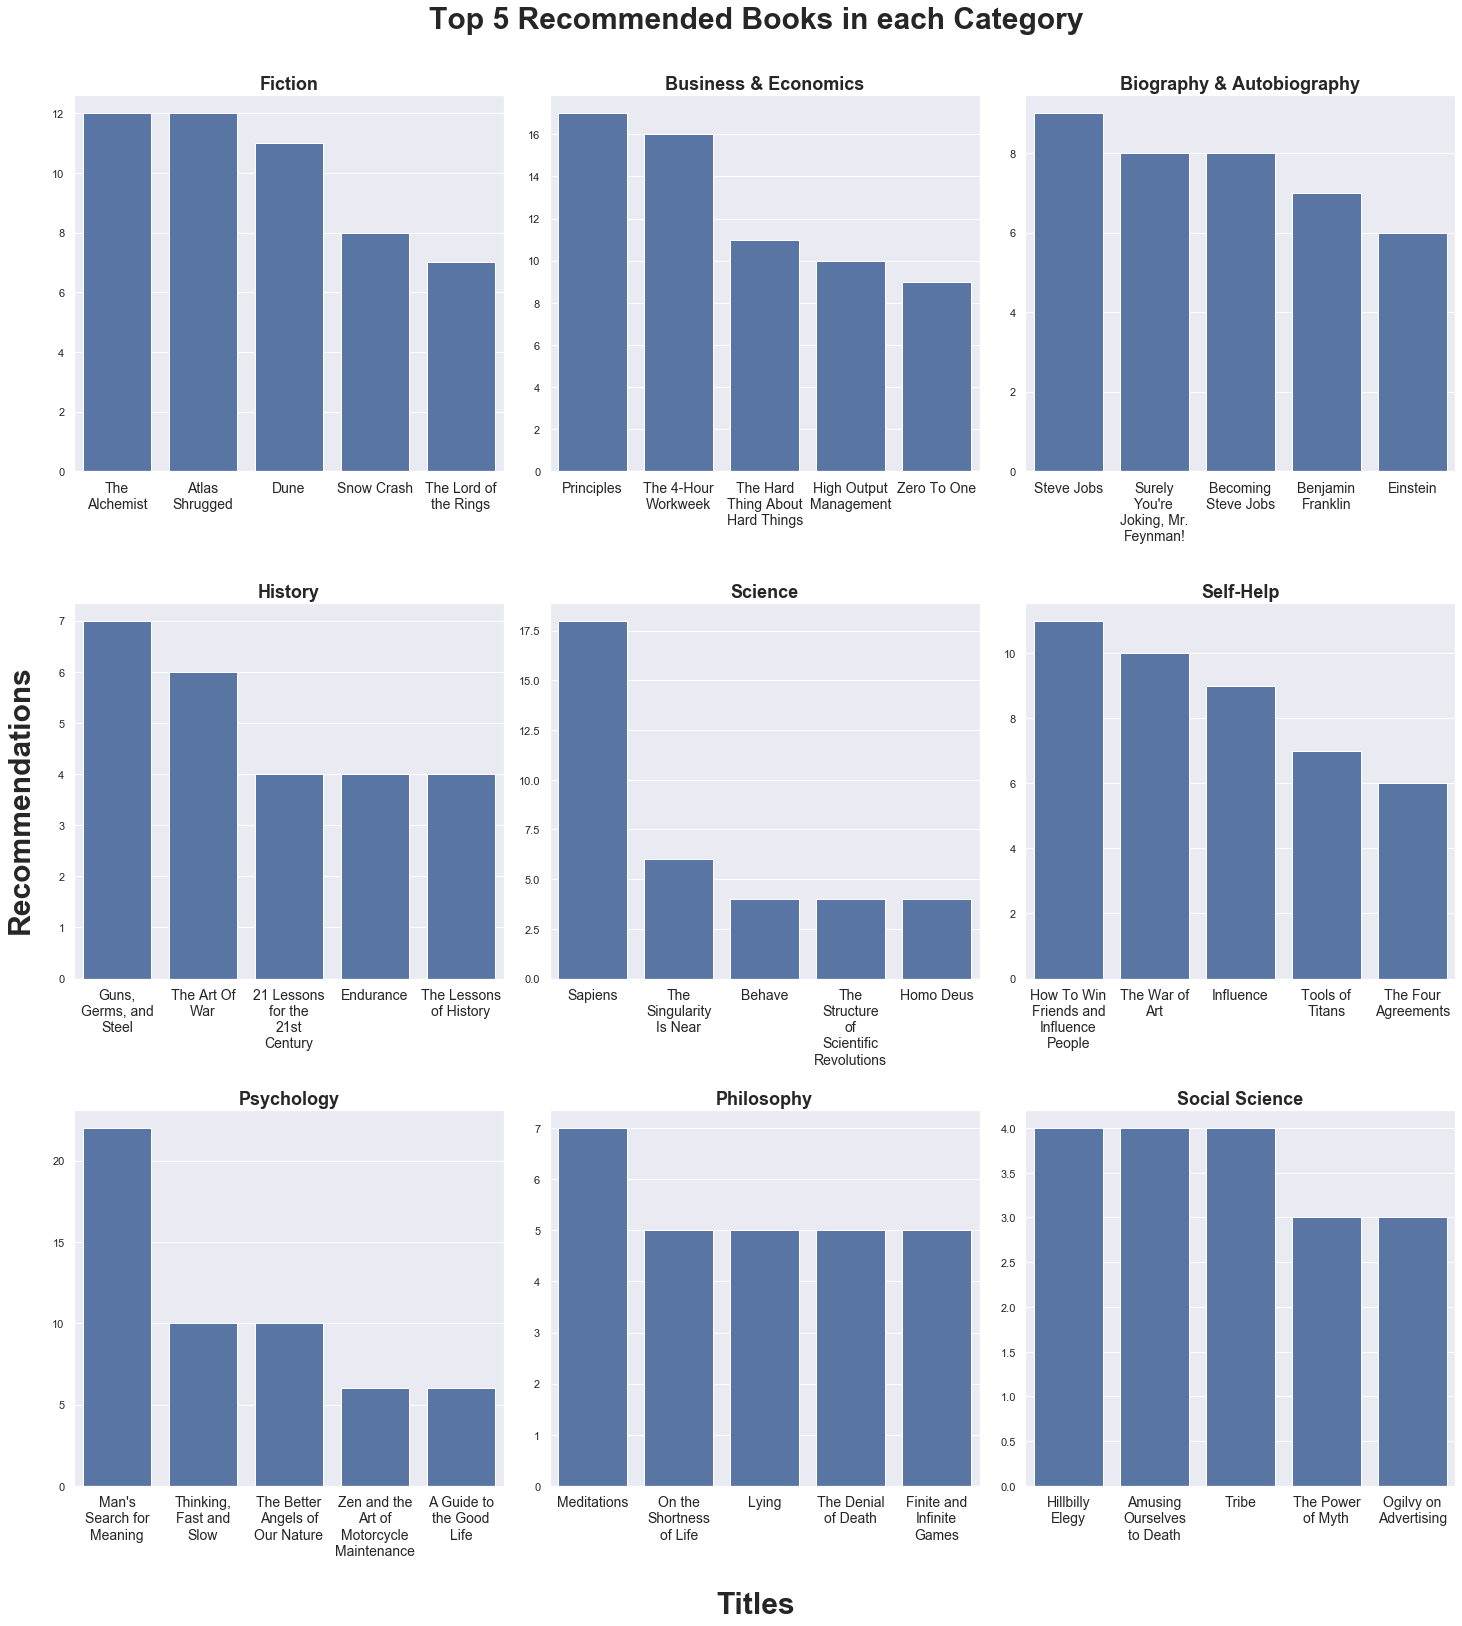

In [26]:
def selection(cat):
    data = books_df[books_df['category'] == cat].sort_values(by='recommender_count', ascending=False).head()
    return data

categories = books_df.category.value_counts().head(9).index.tolist()
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=[20,20])
plt.suptitle('Top 5 Recommended Books in each Category', size=30, y=1.05, fontweight='bold')
fig.tight_layout(h_pad=9)
fig.text(-0.02, 0.5, 'Recommendations', va='center', rotation='vertical', fontweight='bold', fontsize=30)
fig.text(0.5, -0.06, 'Titles', va='center', ha='center', fontweight='bold', fontsize=30)
ax=ax.flatten()
color_base = sb.color_palette()[0]
i=0
for cat in categories:
    sb.barplot(data=selection(cat), x='title', y='recommender_count', ax=ax[i], color=color_base)
    ax[i].set_title(cat, fontweight='bold', fontsize=18)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_xticklabels((textwrap.fill(x.get_text(), width=11) for x in ax[i].get_xticklabels()), fontsize=14)
    i +=1
plt.savefig('top.png', bbox_inches='tight')

The dataset contains a list of 3003 books, namely the most recommended books of many contemporary famous people. Let's look at this list from another angle and see the authors that are most recommended. An author can have multiple books, and if some books have racked up many likes, some authors may likewise have more fans than others.  

***What are the most recommended authors?***

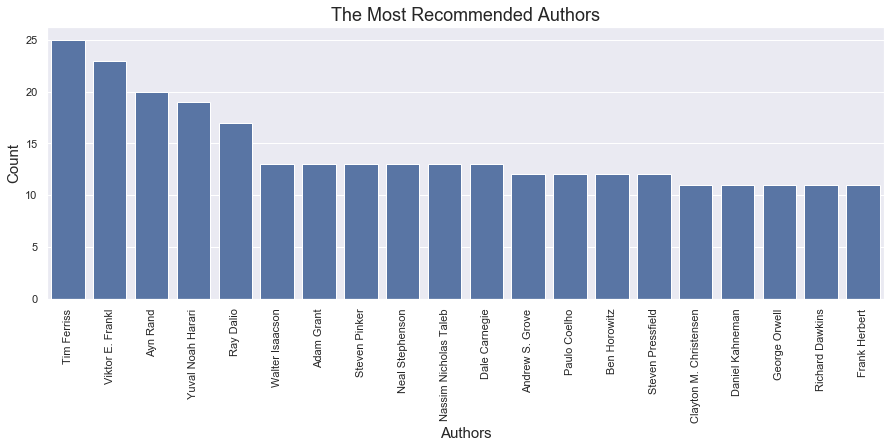

In [28]:
#Grouping by recommender and author to get the unique valuer of authors per recommender: 
data = recommended_books.groupby(['recommender', 'author']).count().reset_index(level=1)
#Plotting the 20 most recommended authors: 
plt.figure(figsize=[15,5])
color_base = sb.color_palette()[0]
sb.barplot(data['author'].value_counts().head(20).index, data['author'].value_counts().head(20).values, color=color_base)
plt.xticks(rotation='vertical')
plt.title('The Most Recommended Authors', size=18)
plt.xlabel('Authors', size=15)
plt.ylabel('Count', size=15)
plt.savefig('author.png', bbox_inches='tight');   

This is a groovy bar plot with many names that appeared in most recommended books plot. However, the order is not the same, and some names are new to the list. This is to say, even if some books might be highly recommended, let's not ignore the authors, as they are equally important. 